# Amazon玩具市场分析

一、数据来源及字段解释

数据来源于kaggle:[Toy Products on Amazon](https://www.kaggle.com/PromptCloudHQ/toy-products-on-amazon)         

字段含义如下：

|   字段名       | 含义     |内容示例  |
| ------------- |:-------------:| -----:|
| uniq_id    | 交易ID | eac7efa5dbd3d667f26eb3d3ab504464|
| product_name     | 产品名称     |   Hornby 2014 Catalogue |
| manufacturer | 生产商      |    Hornby |
| price    | 价格|£3.42|
| number_available_in_stock     | 库存数量     |   5 new |
| number_of_reviews | 评论数    |   15 |
| number_of_answered_questions    | 提问数量 | 1|
| average_review_rating    | 平均评分    |   4.9 out of 5 stars |
| amazon_category_and_sub_category | 类别和子类      |  Hobbies > Model Trains & Railway Sets > Rail Vehicles > Trains |
| customers_who_bought_this_item_also_bough  | 商品集 |http://www.amazon.co.uk/Hornby-R8150-Catalogue-2015/dp/B00S9SUUBE|
| description    | 商品描述   |   Product Description Hornby 2014 Catalogue Box Contains 1 x one catalogue |
| product_information | 产品信息   |   Technical Details Item Weight640 g Product Dimensions29.6 x 20.8 x 1 cm |
| items_customers_buy_after_viewing_this_item | 浏览后购买商品集    |  http://www.amazon.co.uk/Hornby-R8150-Catalogue-2015/dp/B00S9SUUBE  |
| customer_questions_and_answers    | 问题和回答 | Does this catalogue detail all the previous Hornby products please?|
| customer_reviews   | 顾客评价   |   Worth Buying For The Pictures Alone |
| sellers | 卖家     | {"seller"=>{"Seller_name_1"=>"UHD WHOLESALE", "Seller_price_1"=>"£16.99"}} |



二、数据格式转换和清洗

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from efficient_apriori import apriori
data=pd.read_csv(r'./amazon_co-ecommerce_sample.csv',index_col='uniq_id')
print(data.info())


<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, eac7efa5dbd3d667f26eb3d3ab504464 to 94d18e86e504bee1e392df7e5738b18a
Data columns (total 16 columns):
product_name                                   10000 non-null object
manufacturer                                   9993 non-null object
price                                          8565 non-null object
number_available_in_stock                      7500 non-null object
number_of_reviews                              9982 non-null object
number_of_answered_questions                   9235 non-null float64
average_review_rating                          9982 non-null object
amazon_category_and_sub_category               9310 non-null object
customers_who_bought_this_item_also_bought     8938 non-null object
description                                    9349 non-null object
product_information                            9942 non-null object
product_description                            9349 non-null object
items_customers_buy_

从上面我们能看到数据一共有1万条，除product_name字段外都有空值存在。并且一些数值字段的格式是object，而非float，我们要进行相应格式清洗和转换。针对一些字段的空值我们无需做处理，比如库存数量，有些则可以取对应玩具子类的平均值，还有一些则进行删除空值如所属类目和子类。还有一些字段我们需要进行分列比如所属类目和子类，我们更加关注的是这一商品属于哪个具体类别而非它的父类。

In [75]:
data['price']=data['price'].astype(str).apply(lambda x : re.findall(r"\d+.?\d*|$",x)[0].replace(',',''))  #将价格的欧元符号去掉，并且去掉数字中的逗号如2，345这样方便将str格式转换为float
data['price']=pd.to_numeric(data['price'].apply(lambda x : re.findall(r"\d+.?\d*|$",x)[0].replace(',','')))
data['number_of_reviews']=pd.to_numeric(data['number_of_reviews'].astype(str).apply(lambda x :'' if x=='nan' else x.replace(',','')))
data['statue_of_product_in_stock']=data['number_available_in_stock'].astype(str).map(lambda x: x.replace('\xa0',' ').split(' ')[-1])    #对库存数量字段进行分类，因为库存数量这一字段还包括了库存商品状态
data['number_available_in_stock']=data['number_available_in_stock'].astype(str).apply(lambda x:x.split()[0].replace(',','') if x else x)  #分列得到纯数字的库存商品数量
data['number_available_in_stock']=pd.to_numeric(data['number_available_in_stock'].apply(lambda x:'' if x=='nan' else x))   
data['average_review_rating']=data['average_review_rating'].astype(str).apply(lambda x:x.split()[0].replace(',',''))   #去除字符串“out of 5 stars”留下纯数字
data['average_review_rating']=pd.to_numeric(data['average_review_rating'].apply(lambda x:'' if x=='nan' else x))
data['smallest_subcategory']=data['amazon_category_and_sub_category'].astype(str).apply(lambda x:   x.split('>')[-1].strip())   #得到最为精准的所属类目
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, eac7efa5dbd3d667f26eb3d3ab504464 to 94d18e86e504bee1e392df7e5738b18a
Data columns (total 18 columns):
product_name                                   10000 non-null object
manufacturer                                   9993 non-null object
price                                          8565 non-null float64
number_available_in_stock                      7500 non-null float64
number_of_reviews                              9982 non-null float64
number_of_answered_questions                   9235 non-null float64
average_review_rating                          9982 non-null float64
amazon_category_and_sub_category               9310 non-null object
customers_who_bought_this_item_also_bought     8938 non-null object
description                                    9349 non-null object
product_information                            9942 non-null object
product_description                            9349 non-null object
items_customers_

数据格式修改完成后，我们接下来进行数据筛选和空值补充，我们能在上面发现所有数值型数据都没有异常数值，所以我们接下来的主要任务是进行空值补充。

In [76]:
data['price']=data['price'].fillna(value=10.62)    #用价格的中位数进行补充
data['manufacturer']=data['manufacturer'].fillna(value=data['manufacturer'].value_counts()._stat_axis.values.tolist()[0])  #用生产商中的众数填充空值
data['number_of_reviews']=data['number_of_reviews'].fillna(data['number_of_reviews'].mean())
data['average_review_rating']=data['average_review_rating'].fillna(data['average_review_rating'].mean())
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, eac7efa5dbd3d667f26eb3d3ab504464 to 94d18e86e504bee1e392df7e5738b18a
Data columns (total 18 columns):
product_name                                   10000 non-null object
manufacturer                                   10000 non-null object
price                                          10000 non-null float64
number_available_in_stock                      7500 non-null float64
number_of_reviews                              10000 non-null float64
number_of_answered_questions                   9235 non-null float64
average_review_rating                          10000 non-null float64
amazon_category_and_sub_category               9310 non-null object
customers_who_bought_this_item_also_bought     8938 non-null object
description                                    9349 non-null object
product_information                            9942 non-null object
product_description                            9349 non-null object
items_custom

至此数据清洗和格式转换就已经全部完成。

# 三、数据挖掘及分析
## 1.最受欢迎的玩具类型有哪些？


['Vehicles', 'Toys', 'Science Fiction & Fantasy', 'Bead Art & Jewellery-Making', 'Packs & Sets', 'Dice & Dice Games', 'Balloons', 'Banners', 'Card Games', 'Hand Puppets']


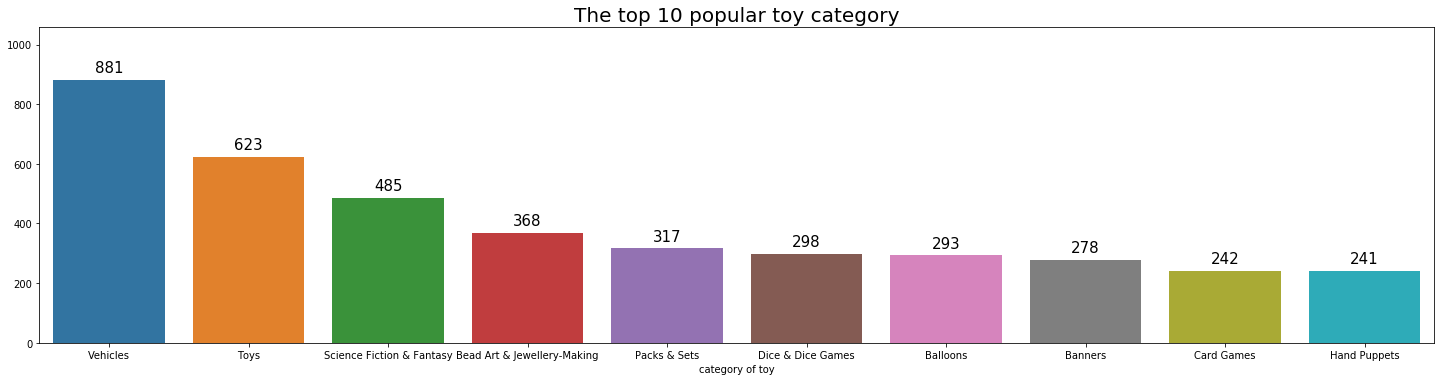

In [77]:
data_of_popular_categery=data.loc[data['smallest_subcategory']!='nan']['smallest_subcategory'].value_counts().head(10)
x=np.arange(10)+1
label=data_of_popular_categery._stat_axis.values.tolist()
print(label)
y=data_of_popular_categery.values.tolist()
plt.figure(figsize=(25,6))
plt.xlabel('category of toy')
plt.title('The top 10 popular toy category',fontsize=20)
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)
sns.barplot(x,y)
sns.barplot(x,y).set(xticklabels=label)
for a,b in zip(x,y):
    plt.text(a-1, b+15, b, ha='center', va= 'bottom',fontsize=15)
plt.show()

## 2.在市场上占据主导地位的品牌方有哪些

['LEGO', 'Disney', 'Oxford Diecast', 'Playmobil', 'Star Wars', 'Mattel', 'Hasbro', 'The Puppet Company', 'MyTinyWorld', 'Corgi']


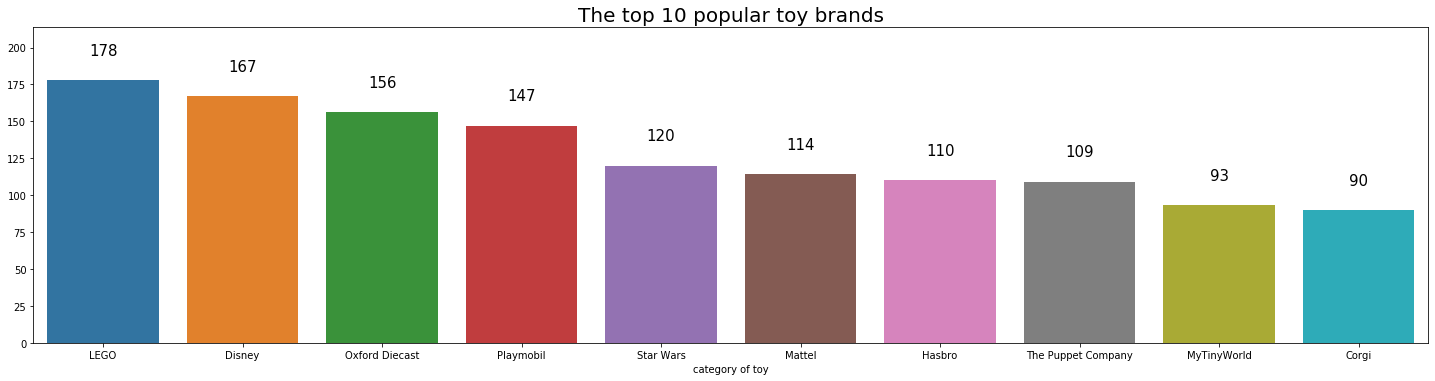

In [78]:
data_of_popular_manufacturer=data['manufacturer'].value_counts().head(10)
x=np.arange(10)+1
label=data_of_popular_manufacturer._stat_axis.values.tolist()
print(label)
y=data_of_popular_manufacturer.values.tolist()
plt.figure(figsize=(25,6))
plt.xlabel('category of toy')
plt.title('The top 10 popular toy brands',fontsize=20)
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)
sns.barplot(x,y)
sns.barplot(x,y).set(xticklabels=label)
for a,b in zip(x,y):
    plt.text(a-1, b+15, b, ha='center', va= 'bottom',fontsize=15)
plt.show()

## 3.根据apriori算法挖掘潜在的物品购买关联

我们字段中有"items_customers_buy_after_viewing_this_item"和"items_customers_buy_after_viewing_this_item"，这样我们就可以得到顾客在同一时间购买的商品组合，将这些商品组合放在一个列表里用efficient-apriori挖掘频繁项集合关联规则。整体流程是先对"items_customers_buy_after_viewing_this_item"字段进行清洗得到包含商品名称的列表，然后再往这个列表里加入顾客购买的"product_name"，这样就能得到一个完整的商品集，然后利用算法进行挖掘。具体过程如下：

In [79]:
def get_tem_list(unsplit_list):
    '''
    将字段先按“|”进行分割，然后再按“/”进行分割，最终得到
    包含商品名称的列表，将之进行返回。
    '''
    unsplit_list=unsplit_list.split('|')
    tem_list=[]
    for i in range(len(unsplit_list)):
        tem_list.append(unsplit_list[i].split('/')[3].strip())
    return tem_list
    
def get_itemsets_rules(field,min_support,min_confidence):
    product_name_list=data.loc[data[field].notnull()]['product_name'].values.tolist()
    also_bought_list=data.loc[data[field].notnull()][field].values.tolist()    
    total_product_list=[]
    for i in range(0,len(also_bought_list)):
        tem_list=get_tem_list(also_bought_list[i])
        tem_list +=tem_list+[product_name_list[i].strip()]
        total_product_list.append(tuple(tem_list))
    itemsets,rules=apriori(total_product_list,min_support=min_support,min_confidence=min_confidence)
    return itemsets,rules

itemsets,rules=get_itemsets_rules('customers_who_bought_this_item_also_bought',min_support=0.002,min_confidence=0.9)
print(itemsets)
print()
print(rules)

{1: {('15pcs-Miniature-Porcelain-Plate-Colorful-Floral',): 22, ('Alison-Gardiner-Traditional',): 21, ('Amazon-EU-S-%C3%A0-r-l-Amazon-co-uk-Printable',): 32, ('Amscan-International',): 139, ('Battery-Tester-Voltage-Buzzer-Alarm',): 19, ('Birthday-Tropical-Assorted-Qualatex-Balloons',): 45, ('Crafted-Cherry-Wooden-Chess-Draughts',): 21, ('Despicable',): 30, ('Dungeon-Masters-Dungeons-Dragons-Accessories',): 25, ('Dungeon-Masters-Dungeons-Dragons-Rulebooks',): 36, ('Dungeons-Dragons-Players-Handbook-Rulebooks',): 49, ('Fiesta-Crafts-White-Moving-Puppet',): 20, ('Gamewright',): 21, ('Girls-10ml-Glitter-Tattoo-Glue',): 27, ('Glitz-Black-Birthday-Bunting-Banner',): 19, ('Glitz-Blue-Latex-Birthday-Balloons',): 26, ('Glitz-Pink-Latex-Birthday-Balloons',): 25, ('Hanging-Glitz-Prism-Birthday-Decorations',): 30, ('Happy-Birthday-Banner-Banners-Decoration',): 20, ('Hornby-R1167-Flying-Scotsman-Electric',): 23, ('Inflatable',): 30, ('Johnsons-Baby-Extra-Sensitive-Wipes',): 19, ('Johnsons-Extra-Sens

由于数据量大，我们将支持度设置为0.002也就是说在这1万条数据里只要出现过20次及以上的我们就把它当做频繁项集，然后我们将置信度调整到0.9，意味着两个物品同时出现的概率必须在90%以上我们才愿意相信两者之间的确存在某种隐秘关系，最终我们发现了上面的几个关联规则。接下来我们继续探索购物者浏览过的商品与其之后购买商品是否有关联规则。

In [80]:
itemsets,rules=get_itemsets_rules('items_customers_buy_after_viewing_this_item',min_support=0.002,min_confidence=0.8)
print(itemsets)
print()
print(rules)

{1: {('12pcs-1-2-inch-Scenery-Landscape',): 14, ('15pcs-Miniature-Porcelain-Plate-Colorful-Floral',): 19, ('Amscan-International',): 81, ('Asmodee-ASMDOBB01EN',): 43, ('Ateam-600pcs-Glitter-Style-S-Clips',): 16, ('BRIO-Rail-Magnetic-Bell-Signal',): 24, ('Bestway-Ocean-Life-122cm',): 18, ('Bicycle-Standard-Index-Playing-Cards',): 15, ('Birthday-Tropical-Assorted-Qualatex-Balloons',): 22, ('Cards-Against-Humanity-UK-edition',): 35, ('Chuggington',): 15, ('Crafted-Cherry-Wooden-Chess-Draughts',): 23, ('Creativity',): 14, ('Dice-spot-pack-10-16mm-diameter-00563',): 14, ('Dungeon-Masters-Dungeons-Dragons-Rulebooks',): 15, ('Dungeons-Dragons-Players-Handbook-Rulebooks',): 53, ('Exploding-Kittens-About-Explosions',): 18, ('Fiesta-Crafts-White-Moving-Puppet',): 18, ('Fiesta-T-2343-Monkey-Puppet',): 32, ('G%C3%BCnther-1159-Childrens-Rainbow-Colours',): 24, ('Girls-10ml-Glitter-Tattoo-Glue',): 24, ('Glitz-Blue-Latex-Birthday-Balloons',): 15, ('Glitz-Pink-Latex-Birthday-Balloons',): 22, ('Hama-Be

我们发现关联规则没有变化，所以最终我们发现了4条关联规则，虽然有些少，但其中也有数据量不够大同时产品名称过于精细所致。毕竟零售行业做关联能发现尿布和啤酒之间有相关性，但是他不会精确到a品牌尿布与b品牌啤酒有相关性，而是会在尿布旁边摆放不同品牌啤酒。

## 4.消费者评论情绪分析
消费者对一件商品的评分和其评论中所包含的情绪是相关的，如果对本次购物非常满意，那么不仅评分会高在评论里面也会显示出积极正面的情绪。接下来我们将评分所体现的情绪进行分类，然后再对评论进行切词，最后利用朴素贝叶斯分类器进行机器学习。
首先我们要来看一下商品评分分布情况：

In [81]:
data_of_rating_and_reviews=data.loc[(data['customer_reviews'].notnull())&(data['average_review_rating'].notnull())][['average_review_rating','customer_reviews']]
print(data_of_rating_and_reviews['average_review_rating'].value_counts())

5.0    5138
4.0    1311
4.5     718
4.8     567
4.7     528
4.3     407
4.6     392
4.4     298
4.9     237
4.2     217
4.1     145
3.9       7
3.6       3
3.0       3
3.3       2
3.5       2
3.7       2
2.3       1
3.8       1
Name: average_review_rating, dtype: int64


我们发现评分在4分以下的数据极少不具备分析价值对此进行舍弃，然后我们决定按照评分将顾客对商品的满意度分为两类，4-4.9分为“excellent”，5分为“perfect”,试图用机器学习找到顾客在碰到完美产品和满意的产品时，评论发生的些许改变。首先我们队数据进行如下转换：

In [82]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
data_of_rating_and_reviews=data_of_rating_and_reviews.loc[(data_of_rating_and_reviews['average_review_rating']>=4)]
data_of_rating_and_reviews['average_review_rating']=data_of_rating_and_reviews['average_review_rating'].astype(str)
data_of_rating_and_reviews.loc[(data_of_rating_and_reviews['average_review_rating'].isin(['4.0','4.1','4.2','4.3','4.4','4.5','4.6','4.7','4.8','4.9'])), 'average_review_rating']='excellent'
data_of_rating_and_reviews.loc[(data_of_rating_and_reviews['average_review_rating']=='5.0'),'average_review_rating']='perfect'
print(data_of_rating_and_reviews['average_review_rating'].value_counts())

perfect      5138
excellent    4820
Name: average_review_rating, dtype: int64


我们能看到相应数据已转换成功，下面我们对数据进行切词处理，并将其分为训练集和测试集，训练贝叶斯分类器，获取模型计算准确率。

In [70]:
def get_cut_words_list(uncut_word_list):
    word_list=[]
    for i in range(len(uncut_word_list)):  
        text_with_spaces=''
        text_cut=word_tokenize(uncut_word_list[i])
        for i in range(len(text_cut)):
            text_with_spaces=text_with_spaces+text_cut[i]+' '
        word_list.append(text_with_spaces)
    return word_list

labels=data_of_rating_and_reviews['average_review_rating'].values.tolist()
features=get_cut_words_list(data_of_rating_and_reviews['customer_reviews'].values.tolist())
train_features,test_features,train_lables,test_lables=train_test_split(features,labels,test_size=0.2)
stop_words=stopwords.words('english')
tf = TfidfVectorizer(stop_words=stop_words, max_df=0.5)
train_features = tf.fit_transform(train_features)
test_features = tf.transform(test_features)  # 上面fit过了，这里transform
clf = MultinomialNB(alpha=0.001).fit(train_features, train_lables) # 多项式贝叶斯分类器 
predicted_lables=clf.predict(test_features)
print('准确率为：', metrics.accuracy_score(test_lables, predicted_lables))  # 计算准确率

准确率为： 0.6857429718875502


最终得到的预测准确率为0.68左右，准确率不够高，原因在于文本中情感区分度不够高，机器难以细腻地识别非常好与很好之间的些许区别。

# 结论
1. 我们最终发现了玩具市场上最受欢迎的十大品类:'Vehicles', 'Toys', 'Science Fiction & Fantasy', 'Bead Art & Jewellery-Making', 'Packs & Sets', 'Dice & Dice Games', 'Balloons', 'Banners', 'Card Games', 'Hand Puppets'。        
2. 找到了占据市场主导地位的厂商:'LEGO', 'Disney', 'Oxford Diecast', 'Playmobil', 'Star Wars', 'Mattel', 'Hasbro', 'The Puppet Company', 'MyTinyWorld', 'Corgi'。            
3. 计算出商品关联规则:{Dungeon-Masters-Dungeons-Dragons-Rulebooks} -> {Dungeons-Dragons-Players-Handbook-Rulebooks}, {Monster-Manual-Dungeons-Rulebook-Rulebooks} -> {Dungeons-Dragons-Players-Handbook-Rulebooks}……             
4. 搭建了一个对用户评论中所包含情绪的预测模型,该模型常用于舆情监控。